In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import random
import tensorflow as tf

In [3]:
data_path = "data/data_clf/"

In [4]:
# create image generator and test and train data sets

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                            validation_split=0.3,
                                                            horizontal_flip=True,
                                                            vertical_flip=True)

image_data_train = image_gen.flow_from_directory(directory=data_path,
                                           target_size=(224, 224),
                                           classes=[f"A{i}" for i in range(1, 21)],
                                           class_mode="categorical", 
                                           subset="training")

image_data_val = image_gen.flow_from_directory(directory=data_path,
                                           target_size=(224, 224),
                                           classes=[f"A{i}" for i in range(1, 21)],
                                           class_mode="categorical", 
                                           subset="validation")

Found 15648 images belonging to 20 classes.
Found 6693 images belonging to 20 classes.


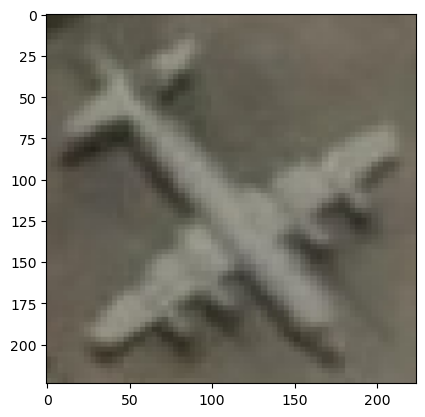

In [5]:
plt.imshow(image_data_train[0][0][7]) # show example of an image

In [8]:
# load pretrained model MobileNet and make all weights Non-trainable


pretrained_model = tf.keras.applications.MobileNet(include_top=False,
                                                   input_shape=(224, 224, 3),
                                                   classes=20)
for layer in pretrained_model.layers:
    layer.trainable = False

In [7]:
pretrained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [18]:
# add some fully connected layers and output layer

model_clf = tf.keras.Sequential([pretrained_model,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dense(20, activation="softmax")
                                ])

model_clf.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=["acc", "Precision", "Recall"])

In [25]:
model_clf = tf.keras.models.load_model("runs/clf/core_model.h5") # load saved model

In [21]:
model_clf.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               6422656   
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 32)                4128      
                                                      

In [19]:
history = model_clf.fit(image_data_train, validation_data=image_data_val, epochs=10) # train

Epoch 1/10
489/489 [==============================] - 260s 529ms/step - loss: 0.7799 - acc: 0.7644 - precision: 0.8959 - recall: 0.6623 - val_loss: 0.6242 - val_acc: 0.8037 - val_precision: 0.8490 - val_recall: 0.7738
Epoch 2/10
489/489 [==============================] - 268s 549ms/step - loss: 0.2717 - acc: 0.9103 - precision: 0.9314 - recall: 0.8933 - val_loss: 0.4159 - val_acc: 0.8800 - val_precision: 0.9027 - val_recall: 0.8648
Epoch 3/10
489/489 [==============================] - 274s 561ms/step - loss: 0.1832 - acc: 0.9402 - precision: 0.9505 - recall: 0.9314 - val_loss: 0.3998 - val_acc: 0.8781 - val_precision: 0.8993 - val_recall: 0.8642
Epoch 4/10
489/489 [==============================] - 266s 544ms/step - loss: 0.1511 - acc: 0.9495 - precision: 0.9583 - recall: 0.9436 - val_loss: 0.4048 - val_acc: 0.8832 - val_precision: 0.8994 - val_recall: 0.8723
Epoch 5/10
489/489 [==============================] - 258s 529ms/step - loss: 0.1228 - acc: 0.9594 - precision: 0.9645 - recall:

In [20]:
model_clf.save("runs/clf/core_model.h5") # save

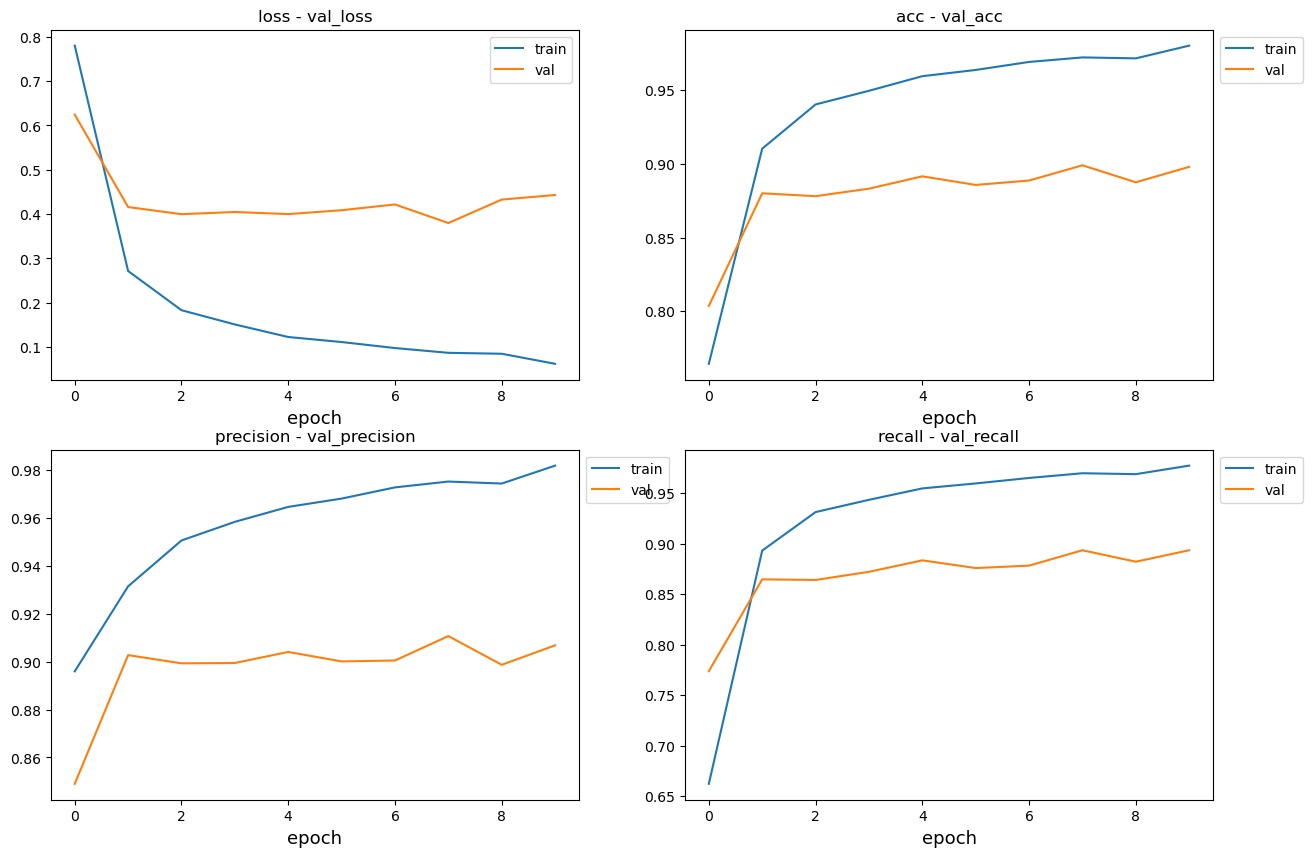

In [21]:
# plotting the history of training
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

axis[0, 0].plot(history.history["loss"], label="train")
axis[0, 0].plot(history.history["val_loss"], label="val")
axis[0, 0].set_title("loss - val_loss")
axis[0, 0].set_xlabel("epoch", fontsize=13)
axis[0, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[0, 1].plot(history.history["acc"], label="train")
axis[0, 1].plot(history.history["val_acc"], label="val")
axis[0, 1].set_title("acc - val_acc")
axis[0, 1].set_xlabel("epoch", fontsize=13)
axis[0, 1].legend(bbox_to_anchor=(1.0, 1.0))

axis[1, 0].plot(history.history["precision"], label="train")
axis[1, 0].plot(history.history["val_precision"], label="val")
axis[1, 0].set_title("precision - val_precision")
axis[1, 0].set_xlabel("epoch", fontsize=13)
axis[1, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[1, 1].plot(history.history["recall"], label="train")
axis[1, 1].plot(history.history["val_recall"], label="val")
axis[1, 1].set_title("recall - val_recall")
axis[1, 1].set_xlabel("epoch", fontsize=13)
axis[1, 1].legend(bbox_to_anchor=(1.0, 1.0))


plt.show()

*We can easily see overfitting (high variance). Lets try to add some regularization (Dropout).*

In [9]:
model_clf = tf.keras.Sequential([pretrained_model,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dropout(0.05),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dropout(0.05),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dropout(0.05),
                                 tf.keras.layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dense(20, activation="softmax")
                                ])

model_clf.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=["acc", "Precision", "Recall"])

In [11]:
model_clf = tf.keras.models.load_model("runs/clf/core_model_reg.h5")

In [10]:
model_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               1

In [11]:
history = model_clf.fit(image_data_train, validation_data=image_data_val, epochs=10)

Epoch 1/10
489/489 [==============================] - 260s 529ms/step - loss: 0.9019 - acc: 0.7267 - precision: 0.8793 - recall: 0.6069 - val_loss: 0.5532 - val_acc: 0.8203 - val_precision: 0.8591 - val_recall: 0.7877
Epoch 2/10
489/489 [==============================] - 273s 559ms/step - loss: 0.3050 - acc: 0.9012 - precision: 0.9247 - recall: 0.8807 - val_loss: 0.4567 - val_acc: 0.8563 - val_precision: 0.8759 - val_recall: 0.8397
Epoch 3/10
489/489 [==============================] - 276s 565ms/step - loss: 0.2083 - acc: 0.9326 - precision: 0.9480 - recall: 0.9209 - val_loss: 0.4041 - val_acc: 0.8760 - val_precision: 0.8963 - val_recall: 0.8640
Epoch 4/10
489/489 [==============================] - 276s 565ms/step - loss: 0.1784 - acc: 0.9440 - precision: 0.9537 - recall: 0.9355 - val_loss: 0.4091 - val_acc: 0.8833 - val_precision: 0.8983 - val_recall: 0.8746
Epoch 5/10
489/489 [==============================] - 276s 565ms/step - loss: 0.1383 - acc: 0.9566 - precision: 0.9621 - recall:

In [12]:
model_clf.save("runs/clf/core_model_reg.h5")

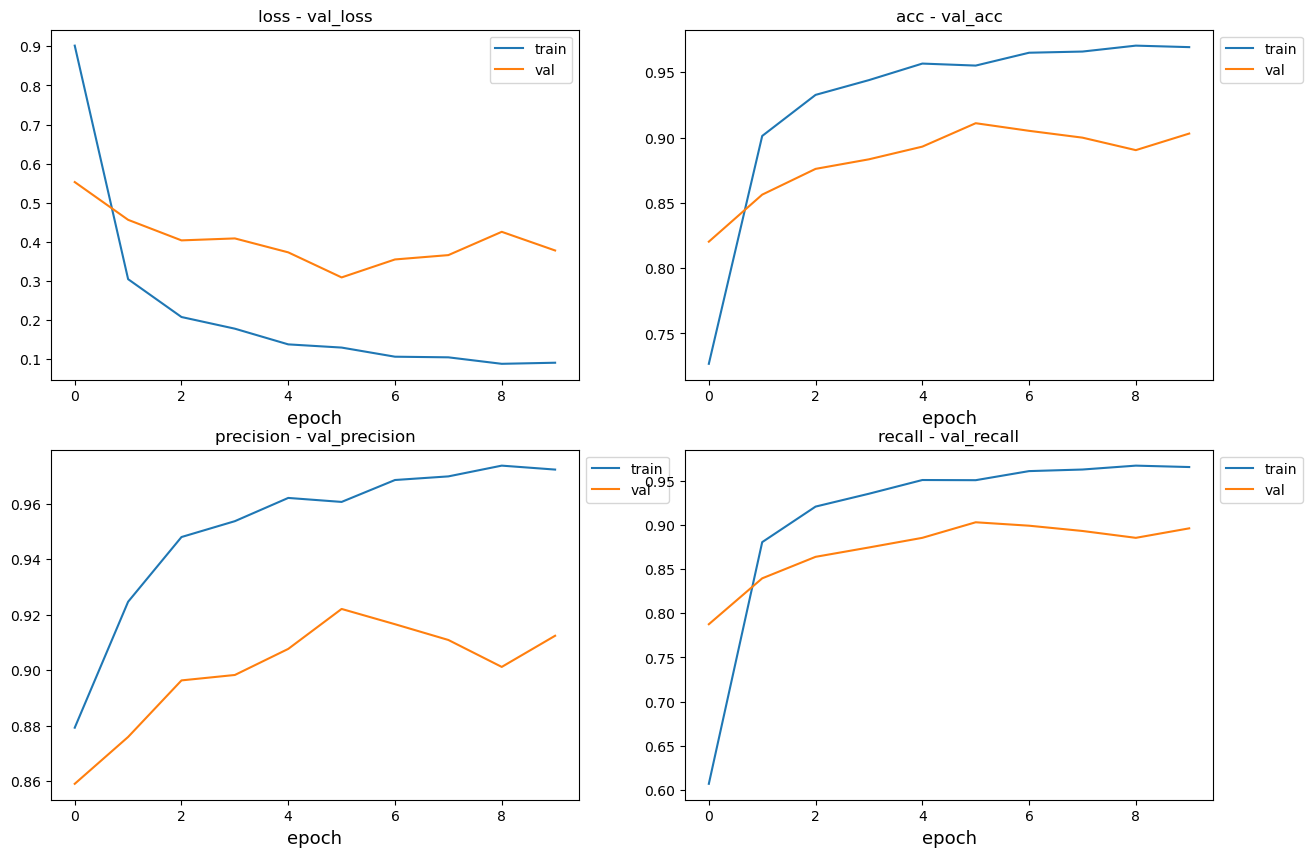

In [13]:
# plotting the history of training
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

axis[0, 0].plot(history.history["loss"], label="train")
axis[0, 0].plot(history.history["val_loss"], label="val")
axis[0, 0].set_title("loss - val_loss")
axis[0, 0].set_xlabel("epoch", fontsize=13)
axis[0, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[0, 1].plot(history.history["acc"], label="train")
axis[0, 1].plot(history.history["val_acc"], label="val")
axis[0, 1].set_title("acc - val_acc")
axis[0, 1].set_xlabel("epoch", fontsize=13)
axis[0, 1].legend(bbox_to_anchor=(1.0, 1.0))

axis[1, 0].plot(history.history["precision"], label="train")
axis[1, 0].plot(history.history["val_precision"], label="val")
axis[1, 0].set_title("precision - val_precision")
axis[1, 0].set_xlabel("epoch", fontsize=13)
axis[1, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[1, 1].plot(history.history["recall"], label="train")
axis[1, 1].plot(history.history["val_recall"], label="val")
axis[1, 1].set_title("recall - val_recall")
axis[1, 1].set_xlabel("epoch", fontsize=13)
axis[1, 1].legend(bbox_to_anchor=(1.0, 1.0))


plt.show()

*Lets add more regularization*

In [27]:
model_clf = tf.keras.Sequential([pretrained_model,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dense(20, activation="softmax")
                                ])

model_clf.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=["acc", "Precision", "Recall"])

In [11]:
model_clf = tf.keras.models.load_model("runs/clf/core_model_reg.h5")

In [28]:
model_clf.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 50176)             0         
                                                                 
 dense_25 (Dense)            (None, 128)               6422656   
                                                                 
 batch_normalization_15 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 128)              

In [29]:
history = model_clf.fit(image_data_train, validation_data=image_data_val, epochs=10)

Epoch 1/10
489/489 [==============================] - 303s 616ms/step - loss: 1.5119 - acc: 0.5350 - precision: 0.7895 - recall: 0.3558 - val_loss: 0.8142 - val_acc: 0.7360 - val_precision: 0.8183 - val_recall: 0.6562
Epoch 2/10
489/489 [==============================] - 301s 615ms/step - loss: 0.6135 - acc: 0.7977 - precision: 0.8593 - recall: 0.7365 - val_loss: 0.4738 - val_acc: 0.8464 - val_precision: 0.8857 - val_recall: 0.8188
Epoch 3/10
489/489 [==============================] - 304s 623ms/step - loss: 0.4262 - acc: 0.8573 - precision: 0.8914 - recall: 0.8266 - val_loss: 0.4241 - val_acc: 0.8600 - val_precision: 0.8835 - val_recall: 0.8398
Epoch 4/10
489/489 [==============================] - 302s 618ms/step - loss: 0.3402 - acc: 0.8865 - precision: 0.9094 - recall: 0.8644 - val_loss: 0.3603 - val_acc: 0.8879 - val_precision: 0.9051 - val_recall: 0.8781
Epoch 5/10
489/489 [==============================] - 301s 617ms/step - loss: 0.2897 - acc: 0.9055 - precision: 0.9226 - recall:

In [30]:
model_clf.save("runs/clf/core_model_reg.h5")

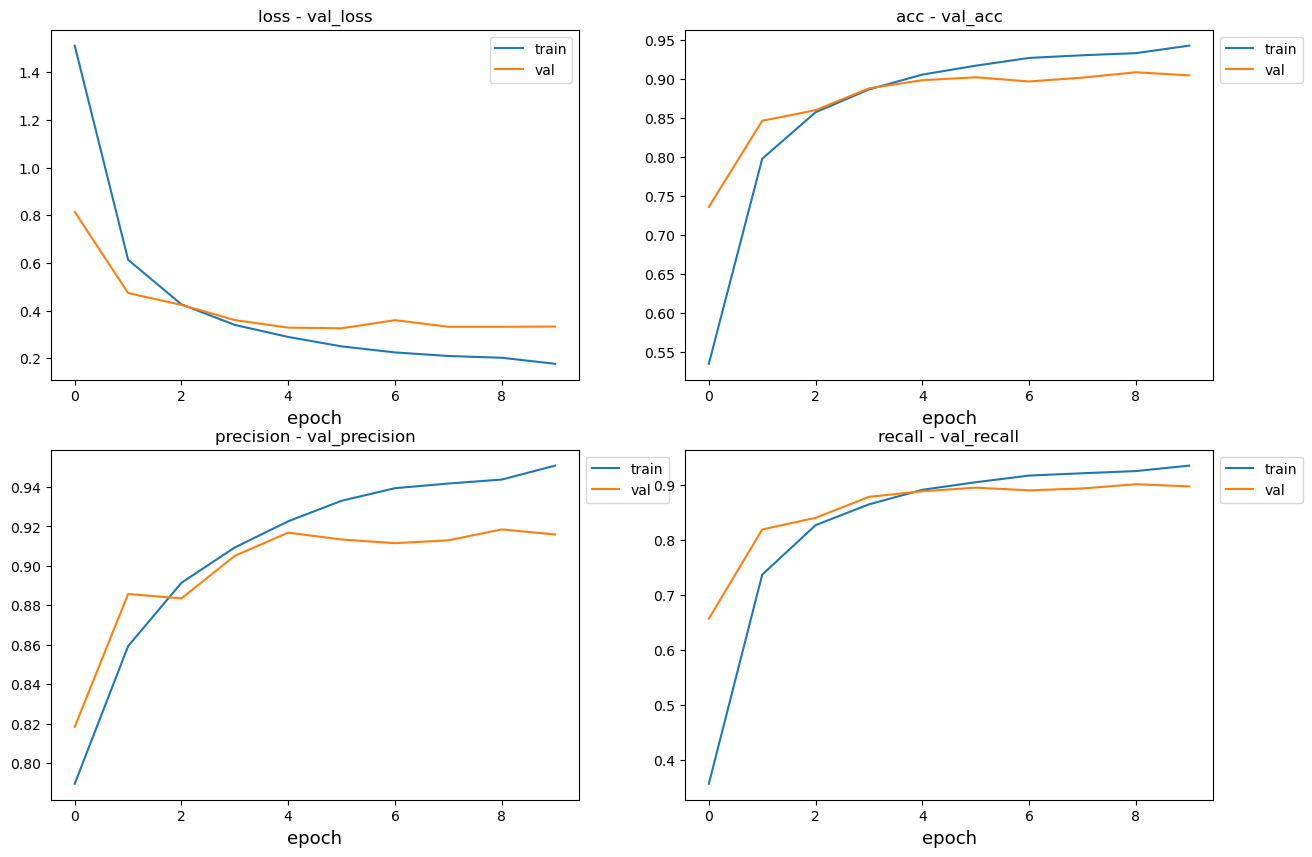

In [31]:
# plotting the history of training
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

axis[0, 0].plot(history.history["loss"], label="train")
axis[0, 0].plot(history.history["val_loss"], label="val")
axis[0, 0].set_title("loss - val_loss")
axis[0, 0].set_xlabel("epoch", fontsize=13)
axis[0, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[0, 1].plot(history.history["acc"], label="train")
axis[0, 1].plot(history.history["val_acc"], label="val")
axis[0, 1].set_title("acc - val_acc")
axis[0, 1].set_xlabel("epoch", fontsize=13)
axis[0, 1].legend(bbox_to_anchor=(1.0, 1.0))

axis[1, 0].plot(history.history["precision"], label="train")
axis[1, 0].plot(history.history["val_precision"], label="val")
axis[1, 0].set_title("precision - val_precision")
axis[1, 0].set_xlabel("epoch", fontsize=13)
axis[1, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[1, 1].plot(history.history["recall"], label="train")
axis[1, 1].plot(history.history["val_recall"], label="val")
axis[1, 1].set_title("recall - val_recall")
axis[1, 1].set_xlabel("epoch", fontsize=13)
axis[1, 1].legend(bbox_to_anchor=(1.0, 1.0))


plt.show()

*Train a bit more epochs*

In [32]:
history = model_clf.fit(image_data_train, validation_data=image_data_val, epochs=10)

Epoch 1/10
489/489 [==============================] - 302s 618ms/step - loss: 0.1539 - acc: 0.9500 - precision: 0.9580 - recall: 0.9430 - val_loss: 0.3528 - val_acc: 0.9033 - val_precision: 0.9140 - val_recall: 0.8969
Epoch 2/10
489/489 [==============================] - 300s 615ms/step - loss: 0.1454 - acc: 0.9534 - precision: 0.9596 - recall: 0.9486 - val_loss: 0.3276 - val_acc: 0.9110 - val_precision: 0.9226 - val_recall: 0.9063
Epoch 3/10
489/489 [==============================] - 302s 618ms/step - loss: 0.1387 - acc: 0.9552 - precision: 0.9615 - recall: 0.9490 - val_loss: 0.3407 - val_acc: 0.9065 - val_precision: 0.9141 - val_recall: 0.9011
Epoch 4/10
489/489 [==============================] - 300s 615ms/step - loss: 0.1177 - acc: 0.9603 - precision: 0.9660 - recall: 0.9563 - val_loss: 0.3275 - val_acc: 0.9147 - val_precision: 0.9233 - val_recall: 0.9102
Epoch 5/10
489/489 [==============================] - 300s 615ms/step - loss: 0.1327 - acc: 0.9576 - precision: 0.9629 - recall:

In [35]:
model_clf.save("runs/clf/core_model_reg.h5")

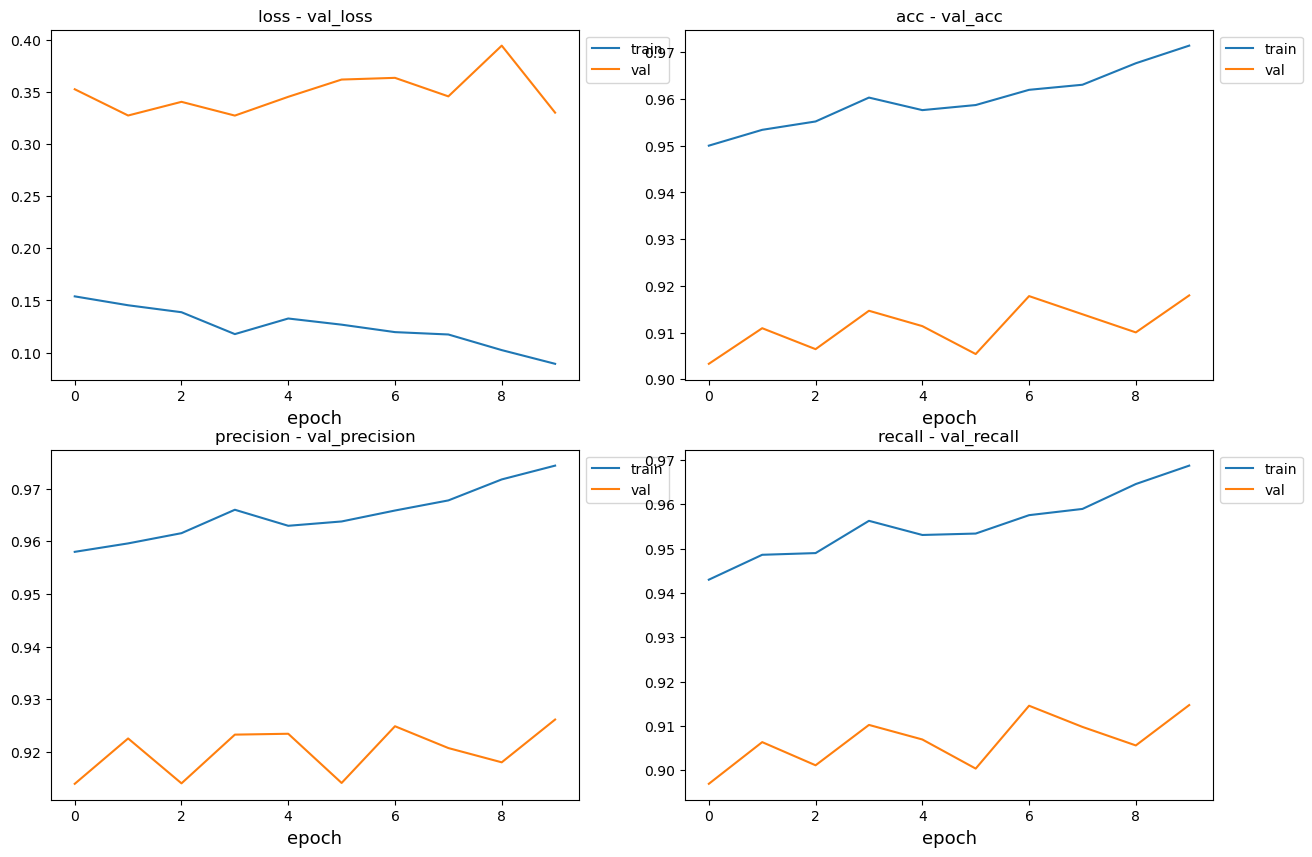

In [34]:
# plotting the history of training
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

axis[0, 0].plot(history.history["loss"], label="train")
axis[0, 0].plot(history.history["val_loss"], label="val")
axis[0, 0].set_title("loss - val_loss")
axis[0, 0].set_xlabel("epoch", fontsize=13)
axis[0, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[0, 1].plot(history.history["acc"], label="train")
axis[0, 1].plot(history.history["val_acc"], label="val")
axis[0, 1].set_title("acc - val_acc")
axis[0, 1].set_xlabel("epoch", fontsize=13)
axis[0, 1].legend(bbox_to_anchor=(1.0, 1.0))

axis[1, 0].plot(history.history["precision"], label="train")
axis[1, 0].plot(history.history["val_precision"], label="val")
axis[1, 0].set_title("precision - val_precision")
axis[1, 0].set_xlabel("epoch", fontsize=13)
axis[1, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[1, 1].plot(history.history["recall"], label="train")
axis[1, 1].plot(history.history["val_recall"], label="val")
axis[1, 1].set_title("recall - val_recall")
axis[1, 1].set_xlabel("epoch", fontsize=13)
axis[1, 1].legend(bbox_to_anchor=(1.0, 1.0))


plt.show()

## Results

In [9]:
model_clf = tf.keras.models.load_model("runs/clf/core_model_reg.h5")

In [13]:
val_acc = 0.918
val_precision = 0.9262
val_recall = 0.9147
val_F1 = 2 * val_precision * val_recall / (val_precision + val_recall)

In [18]:
print(f"The best model:\n\nval_acc: {val_acc}\nval_precision: {val_precision}\nval_recall: {val_recall}\nval_F1: {round(val_F1, 4)}")

The best model:

val_acc: 0.918
val_precision: 0.9262
val_recall: 0.9147
val_F1: 0.9204


1/1 [==============================] - 0s 310ms/step


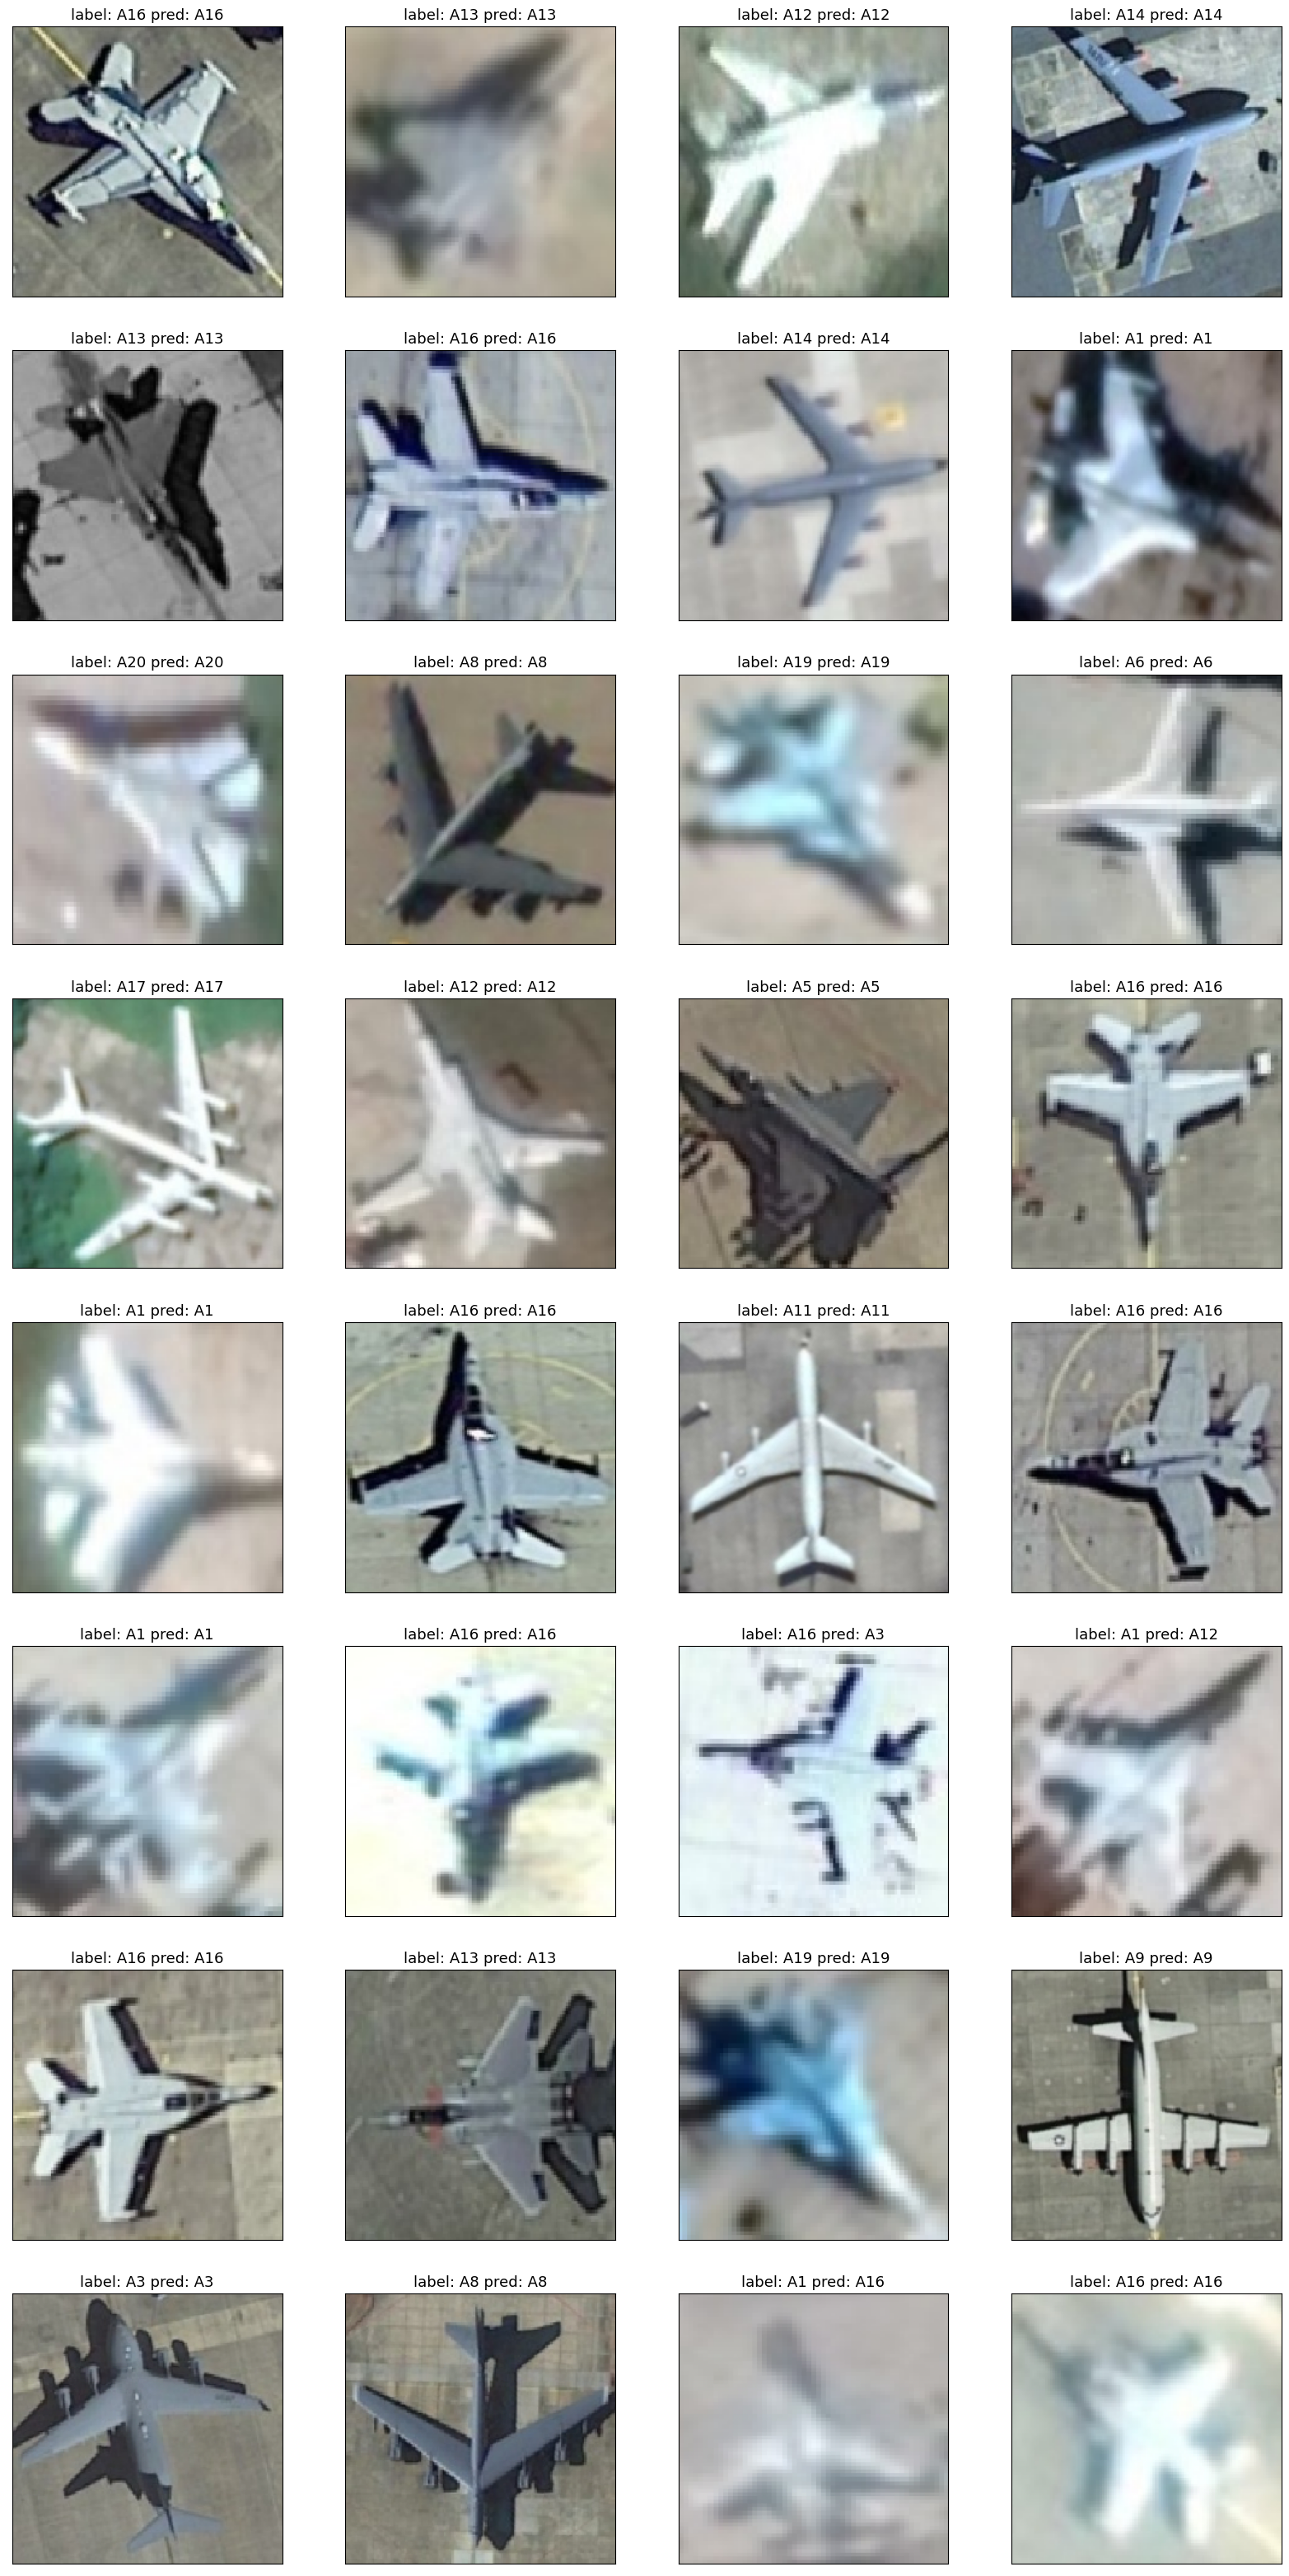

In [29]:
batch_index = 3 # feel free to change it

image_batch = image_data_val[batch_index][0]
label_batch = image_data_val[batch_index][1]
predictions = model_clf.predict(image_batch)


fig, axis = plt.subplots(8, 4, figsize=(20, 40))

for i in range(8):
    for j in range(4):
        image = image_batch[i * 4 + j]
        
        axis[i, j].set_xticks([])
        axis[i, j].set_yticks([])
        axis[i, j].set_title(f"label: A{label_batch[i * 4 + j].argmax() + 1} pred: A{predictions[i * 4 + j].argmax() + 1}", fontsize=13)
        axis[i, j].imshow(image)

*Easy to notice that our model makes mistakes mostly on images with really bad quality*